OmniDataScience

In [147]:
pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [148]:
pip install tensorflow_decision_forests --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
#!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic
#!jupyter nbconvert --to pdf /content/OmniDS.ipynb

In [150]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats
sns.set(style="darkgrid")

import tensorflow as tf
import tensorflow_decision_forests as tfdf

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split, cross_val_score, learning_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, chi2


from sklearn.cluster import AffinityPropagation
from Levenshtein import distance as LevenshteinDistance

SEED = 42
import string
import warnings
warnings.filterwarnings('ignore')

In [151]:
class DataFrameToolBox:
  def __init__(self, trainData):
    self.__seperationNumber = len(trainData)

  @staticmethod
  def RemoveFeatures(data : pd.DataFrame, features):
    if type(features) == str:
      if features in data:
        data.drop(columns = features, inplace = True)
        return
    else:
      for feature in features:
        if feature in data:
          data.drop(columns = [feature], inplace = True)

  @staticmethod
  def CombineData(trainData, testData):
    return pd.concat([trainData, testData], sort=True).reset_index(drop=True)

  @staticmethod
  def AddFeature(data : pd.DataFrame, feature):
    data[feature.name] = feature.array
    return data

  @staticmethod
  def SplitData(data, seperationNumber):
    return data.loc[:seperationNumber-1], data.loc[seperationNumber:]
  def SplitData(self, data):
    return self.SplitData(data, self.__seperationNumber)

  @staticmethod
  def FindFloatFeatures(data, removeFeatures = ""):
    numeric_features = data.select_dtypes(include = np.number).columns
    if removeFeatures == "" :
      return numeric_features.tolist()
    else:
      return numeric_features.drop(removeFeatures).tolist()

  @staticmethod
  def FindIntergerFeatures(data, removeFeatures = ""):
    interger_features = data.select_dtypes(include = int).columns
    interger_features = ListToolBox.RemoveFeatures(interger_features.tolist(), removeFeatures)
    return interger_features

  @staticmethod
  def FindStringFeatures(data : pd.DataFrame, removeFeatures : list = []):
    non_numeric_features = data.select_dtypes(exclude = np.number).columns.tolist()
    if removeFeatures == [] or removeFeatures not in non_numeric_features:
      return non_numeric_features
    else:
      return non_numeric_features.drop(removeFeatures).tolist()

  @staticmethod
  def FindCategoricalFeatures(data, removeFeatures = ""):
    return DataFrameToolBox.FindStringFeatures(data, removeFeatures)

  @staticmethod
  def FindUndersizeFeatures(data, removeFeatures = ""):
    undersize_features = []
    undersize_threshold = data.shape[0] * 0.1
    for feature in data.keys():
      if len(data.groupby(feature)) < undersize_threshold and feature not in removeFeatures:
        undersize_features.append(feature)
    return undersize_features

  @staticmethod
  def TestUniqueValueUpperRatio(data, feature, ratio):
    return len(data[feature].unique()) / data.shape[0] > ratio
  @staticmethod
  def TestUniqueValueLowerRatio(data, feature, ratio):
    return DataFrameToolBox.TestUniqueValueUpperRatio(data, feature, ratio) == False

  @staticmethod
  def FindNominalCategoricalFeatures(data, removeFeatures = "", categoricalFeatures = []):
    categorical_features = []
    if categoricalFeatures == []:
      categorical_features = DataFrameToolBox.FindCategoricalFeatures(data, removeFeatures)
    else:
      categorical_features = categoricalFeatures
    nominal_categorical_features = []
    for feature in categorical_features :
      if DataFrameToolBox.TestNominalCategoricalFeatures(data[feature]):
        nominal_categorical_features.append(feature)
    return nominal_categorical_features

  @staticmethod
  def TestNominalCategoricalFeatures(categoricalFeatureData):
    all_value_in_feature = categoricalFeatureData.unique()
    if type(all_value_in_feature) != np.ndarray:
      return False
    length_all_value_in_feature = len(all_value_in_feature)
    return length_all_value_in_feature > 2

  @staticmethod
  def ContainsValue(data, values) -> bool:
    if type(values) != list:
      return data.isin([values]).any()
    else:
      return data.isin(values).any()

  @staticmethod
  def ContainsColumns(data, columns) -> bool:
    return set(columns).issubset(data.columns)

In [152]:
class ListToolBox:
  @staticmethod
  def FilterList(listData, excludeFeatures):
    exclude_features = set(excludeFeatures)
    return [x for x in listData if x not in exclude_features]

  @staticmethod
  def RemoveFeatures(listData : list, features):
    for feature in features:
      if feature in listData:
        listData.remove(feature)
    return listData


In [153]:
class DictionaryToolBox:
  @staticmethod
  def CreateDictionary(keys : list, values : list = []):
    dictionary = {}
    for i in range(len(keys)):
      if values == []:
        dictionary[keys[i]] = []
      else:
        dictionary[keys[i]] = values[i]
    return dictionary

  @staticmethod
  def MergeDictionary(originalDictionary : dict, secondDictionary : dict):
    originalDictionary.update(secondDictionary)
    return originalDictionary


In [154]:
class Logger:
  def __init__(self, verbose = False) -> None:
    self._verbose = verbose

  def Print(self, text, sep = ' ', end = '\n', printAll = False):
    if self._verbose:
      text_type = type(text)
      if text_type != str:
        if text_type == pd.DataFrame and not printAll:
          display(text.head())
        else:
          display(text)
      else:
        print(text, sep = sep, end = end)


In [155]:
class ParameterGrid(Logger):
  def __init__(self, parameterNames : list = [], parameterValues : list = [], dictionary : dict = None, verbose = False):
    super().__init__(verbose)
    if dictionary != None:
      self.__SetParametersFromDict(dictionary)
    else:
      self.__SetParametersFromLists(parameterNames, parameterValues)

  def __SetParametersFromLists(self, parameterNames : list = [], parameterValues : list = []):
    self._parameterGrid = DictionaryToolBox.CreateDictionary(parameterNames, parameterValues)
    self.Print(f"Create {self._parameterGrid}")

  def __SetParametersFromDict(self, dictionary : dict = None):
    self._parameterGrid = dictionary
    self.Print(f"Create {self._parameterGrid}")

  def Copy(self, dictionary : dict):
    self._verbose = False
    self.__SetParametersFromLists(list(dictionary.keys()), list(dictionary.values()))
    self._verbose = True
    self.Print(f"Copy {self._parameterGrid}")
    return self

  def GetParameters(self):
    return self._parameterGrid

  def GetParameter(self, parameter):
    return self.GetParameters()[parameter]

  def SetParameter(self, parameter, value):
    self._parameterGrid[parameter] = value

  def ApplyFunction(self, function, inplace = True):
    if inplace:
      parameter_grid = self
    else:
      parameter_grid = ParameterGrid().Copy(self._parameterGrid)

    for (parameter_key, parameter_value) in self._parameterGrid.items():
      parameter_grid.SetParameter(parameter_key, function(parameter_value))

    self.Print(f"ApplyFunction {parameter_grid.GetParameters()}")
    return parameter_grid

In [156]:
def ReadCSV(urldata):
  data = pd.read_csv(urldata, header = None)
  header = 'infer'
  for dtype in data.dtypes:
    if dtype != object:
      header = None
  data = pd.read_csv(urldata, header = header)
  if 'Id' in data:
    data.drop('Id', axis=1, inplace = True)
  return data

test_data = ReadCSV("test.csv")
display(test_data.head())
train_data = ReadCSV("train.csv")
display(train_data.head())
train_label_data = ReadCSV("sample_submission.csv")
display(train_label_data.head())

test_data2 = test_data
train_data2 = train_data
train_label_data2 = train_label_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,SalePrice
0,169277.052498
1,187758.393989
2,183583.683570
3,179317.477511
4,150730.079977


In [157]:
def split_dataset(dataset, test_ratio=0.30):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(train_data2)
print("{} examples in training, {} examples in testing.".format(
    len(train_ds_pd), len(valid_ds_pd)))

1014 examples in training, 446 examples in testing.


In [158]:
label = 'SalePrice'
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)
valid_ds = tfdf.keras.pd_dataframe_to_tf_dataset(valid_ds_pd, label=label, task = tfdf.keras.Task.REGRESSION)

In [159]:
rf = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.REGRESSION)
rf.compile(metrics=["mse"])

Use /tmp/tmprw18zzyc as temporary training directory


In [160]:
rf.fit(x=train_ds)

Reading training dataset...
Training dataset read in 0:00:01.384635. Found 1014 examples.
Training model...
Model trained in 0:00:04.793181
Compiling model...
Model compiled.


In [161]:
tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

In [162]:
inspector = rf.make_inspector()
inspector.evaluation()

Evaluation(num_examples=1014, accuracy=None, loss=None, rmse=31189.7919299493, ndcg=None, aucs=None, auuc=None, qini=None)

In [163]:
evaluation = rf.evaluate(x=valid_ds,return_dict=True)

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

1/1 [==============================] - 1s 1s/step - loss: 0.0000e+00 - mse: 563728640.0000
loss: 0.0000
mse: 563728640.0000


In [164]:
print(f"Available variable importances:")
for importance in inspector.variable_importances().keys():
  print("\t", importance)

Available variable importances:
	 SUM_SCORE
	 NUM_AS_ROOT
	 INV_MEAN_MIN_DEPTH
	 NUM_NODES


In [165]:
test_data3 = pd.read_csv("test.csv")
ids = test_data3.pop('Id')
test_data3

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [166]:
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data3,task = tfdf.keras.Task.REGRESSION)

preds = rf.predict(test_ds)

output = pd.DataFrame({'SalePrice': preds.squeeze()})

output.head()

2/2 [==============================] - 1s 33ms/step


,SalePrice
0,128498.125000
1,152132.515625
2,183340.343750
3,184119.593750
4,195590.031250


In [167]:
sample_submission_df = train_label_data2
sample_submission_df['SalePrice'] = rf.predict(test_ds)
sample_submission_df.to_csv('submission_test.csv', index=False)
sample_submission_df.head()

2/2 [==============================] - 0s 39ms/step


,SalePrice
0,128498.125000
1,152132.515625
2,183340.343750
3,184119.593750
4,195590.031250


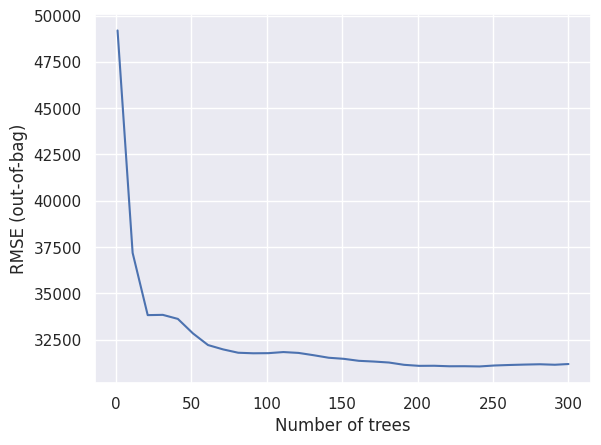

In [168]:
logs = rf.make_inspector().training_logs()
plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.show()

In [169]:
total = train_data.isna().sum().sort_values(ascending=False)
percent = (train_data.isna().sum()/train_data.isna().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [170]:
class OmniDS(Logger):
  def __init__(self, urlTrain, urlTest, urlTrainLabel = None, targetFeature = None, idFeature = None, uselessFeatures : list = [], verbose = False):
    super().__init__(verbose)

    self._trainData = self.__ReadCSV(urlTrain, idFeature)
    self._trainLabelData = self.__ReadCSV(urlTrainLabel, idFeature)
    self._testData = self.__ReadCSV(urlTest, idFeature)

    self._targetFeature = targetFeature
    self._targetFeatureInTrainData = self._targetFeature in self._trainData
    if self._targetFeatureInTrainData:
      self._targetFeatureType = self._trainData.dtypes[self._targetFeature]
    else:
      self._targetFeatureType = self._trainLabelData.dtypes[0]
    self._uselessFeatures = uselessFeatures

  def Predict(self, crossValidationNumber : int = 5, splitNumber : int = 10, verbose : bool = None):
    if verbose != None:
      self._verbose = verbose
    self.CleanData()
    statistical_information = self.ExploreData()
    x_train, y_train, x_test = self.PreprocessingData(statistical_information)
    trained_model = self.FitModel(self.ChooseModel(), x_train, y_train, crossValidationNumber)
    return self.PredictData(trained_model, x_test, x_train, y_train, crossValidationNumber, splitNumber)

  def CleanData(self):
    Cleaner = DataCleaner(self._verbose);
    if self._targetFeatureInTrainData:
      Cleaner.AutoFillNAInTrainTestData(self._trainData, self._testData, featuresToIgnore=[self._targetFeature])
    else:
      Cleaner.AutoFillNAInTrainTestData(self._trainData, self._testData)

  def ExploreData(self):
    Explorer = DataExplorer(self._verbose)
    return Explorer.GetStatisticalInformation(self._trainData)

  def PreprocessingData(self, statisticalInformation):
    if self._targetFeatureInTrainData:
      Processor = DataProcessor(statisticalInformation = statisticalInformation, targetFeature = self._targetFeature, uselessFeatures = self._uselessFeatures, verbose = self._verbose)
    else:
      Processor = DataProcessor(statisticalInformation = statisticalInformation, uselessFeatures = self._uselessFeatures, verbose = self._verbose)
    return Processor.ProccesingData(self._trainData, self._testData, self._trainLabelData)

  def ChooseModel(self):
    model_finder = ModelFinder(self._verbose)
    return model_finder.ChooseModel()

  def FitModel(self, model, xTrain, yTrain, crossValidationNumber):
    model_fitter = ModelFitter(self._verbose)
    return model_fitter.FitModel(model, xTrain, yTrain, crossValidationNumber)

  def PredictData(self, model, xTest, xTrain, yTrain, crossValidationNumber, splitNumber):
    data_predictor = DataPredictor(self._verbose)
    data_predictor.PredictBinomial(model, xTest, self._idFeature, self._targetFeature, self._targetFeatureType, self._testData)
    if self._verbose:
      data_predictor.PredictionAnalysis(model, xTrain, yTrain, splitNumber = splitNumber, crossValidationNumber = crossValidationNumber)

  def __ReadCSV(self, urldata, idFeature = 'Id'):
    if urldata == None:
      return None
    data = pd.read_csv(urldata, header = None)
    header = 'infer'
    for dtype in data.dtypes:
      if dtype != object:
        header = None
        break
    data = pd.read_csv(urldata, header = header)
    if idFeature in data:
      data.drop(idFeature, axis=1, inplace = True)
    self.Print(data)
    return data


In [171]:
class DataCleaner(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)
    pass

  def AutoFillNAInTrainTestData(self, trainData : pd.DataFrame, testData : pd.DataFrame, missingValue = np.nan, featuresToIgnore : list = []):
    self.Print(f"Starting auto fill for trainData")
    auto_fill_strategy = self.__AutoFillNA(trainData, missingValue, featuresToIgnore)
    self.Print(f"")
    self.Print(f"Starting auto fill for testData")
    self.__ApplyAutoFillStrategy(testData, auto_fill_strategy, missingValue, featuresToIgnore)
    self.__AutoFillNA(testData, missingValue, featuresToIgnore, testData = True)

  def __AutoFillNA(self, data, missingValue = np.nan, featuresToIgnore = [], testData = False):
    self.Print(f"Missing values : ")
    missing_data = self.__PrintMissingData(data)
    categorie_with_na = self.FindCategorieWithNA(missing_data)
    categorie_with_na = ListToolBox.FilterList(categorie_with_na, featuresToIgnore)
    return self.__FillBasicNA(data, missing_data, categorie_with_na, missingValue, testData)

  def __ApplyAutoFillStrategy(self, data, autoFillStrategy, missingValue = np.nan, featuresToIgnore = []):
    for feature_to_remove in autoFillStrategy["removedFeatures"]:
      self.__DeleteMissingValue(data, feature_to_remove)
      self.Print(f"for {feature_to_remove}")

  def __PrintMissingData(self, data):
    total = data.isna().sum().sort_values(ascending=False)
    percent = (data.isna().sum()/data.isna().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    self.Print(missing_data, printAll = True)
    return missing_data

  def FindCategorieWithNA(self, missingData):
    return [categorie_value[0] for categorie_value in missingData["Total"].items() if categorie_value[1] > 0]

  def __FillBasicNA(self, data, missingData, categorieWithNA, missingValue = np.nan, testData = False):
    auto_fill_strategy = {"removedFeatures" : []}
    for categorie in categorieWithNA:
      if self.__ToManyMissingValueTest(missingData, categorie) and not testData:
        self.__DeleteMissingValue(data, categorie)
        auto_fill_strategy["removedFeatures"].append(categorie)
      else:
        if is_numeric_dtype(data[categorie]):
          if self.__CorrelationTest(data, categorie) and not testData:
            self.__DeleteMissingValue(data, categorie)
            auto_fill_strategy["removedFeatures"].append(categorie)
          else:
            self.__FillNaWithMedian(data[categorie], missingValue)
        else:
          if self.__TestCreateNewNACategorie(missingData, data, categorie):
            self.__CreateNewNACategorie(data[categorie], missingValue)
          else:
            self.__FillNaWithMostFrequentValue(data[categorie], missingValue)
      self.Print(f"for {categorie}")
    return auto_fill_strategy

  def __ToManyMissingValueTest(self, missingData, feature):
    if missingData["Percent"][feature] > 0.15:
      self.Print(f"Percent of mising value for {feature} is {missingData['Percent'][feature]}")
      return True
    return False

  def __CorrelationTest(self, data, feature):
    correlated_features = [correlated_feature[0] for correlated_feature in data.corr()[feature].items() if correlated_feature[1] > 0.4 and correlated_feature[0] != feature]
    if len(correlated_features) > 0:
      self.Print(f"{feature} is extremely correlated to {correlated_features}")
      return True
    return False

  def __DeleteMissingValue(self, data, categorie):
    self.Print(f"Delete ", end = "")
    DataFrameToolBox.RemoveFeatures(data, categorie)

  def __FillNaWithMedian(self, data, missingValue = np.nan):
      self.Print("Fill Na by ", end = "")
      data.fillna(data.median(), inplace = True)
      self.Print("the median ", end = "")
  def __FillNAWithMedianGroupByCategories(self, data, keyWithNA, categories):
      return data.groupby(categories)[keyWithNA].apply(lambda x: x.fillna(x.median()))

  def __TestCreateNewNACategorie(self, missingData, data, categorie):
    return missingData["Total"][categorie] > data.shape[0] / len(data[categorie].unique())

  def __CreateNewNACategorie(self, data, missingValue = np.nan, newCategorie = "_missing_"):
      self.Print(f"We create a new categorie : ", end = "")
      data.fillna(newCategorie, inplace = True)
      self.Print(f"{newCategorie} ", end = "")

  def __FillNaWithMostFrequentValue(self, data, missingValue = np.nan):
      self.Print("Fill Na by ", end = "")
      data.fillna(data.value_counts().index[0], inplace = True)
      self.Print("the most frequent value ", end = "")

  def FillNaWithMean(self, data, missingValue = np.nan):
      self.Print("Fill Na by ", end = "")
      data.fillna(data.mean(), inplace = True)
      self.Print("the mean ", end = "")

  def FillNAWithValue(self, data, keyWithNA, value):
    return data[keyWithNA].fillna(value)

  def FillOtherNA(data):
    imputer = KNNImputer()
    imputer.fit_transform(data)

In [172]:
"""
train_data2 = train_data2.drop((missing_data[missing_data['Total'] > 1]).index,1)
train_data2 = train_data2.drop(train_data2.loc[train_data2['Electrical'].isnull()].index)
train_data2.isnull().sum().max() #just checking that there's no missing data missing...
"""

"\ntrain_data2 = train_data2.drop((missing_data[missing_data['Total'] > 1]).index,1)\ntrain_data2 = train_data2.drop(train_data2.loc[train_data2['Electrical'].isnull()].index)\ntrain_data2.isnull().sum().max() #just checking that there's no missing data missing...\n"

In [173]:
Cleaner = DataCleaner(True);
Cleaner.AutoFillNAInTrainTestData(train_data, test_data)

Starting auto fill for trainData
Missing values : 


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
...,...,...
Heating,0,0.000000
HeatingQC,0,0.000000
MSZoning,0,0.000000
1stFlrSF,0,0.000000


Percent of mising value for PoolQC is 0.9952054794520548
Delete for PoolQC
Percent of mising value for MiscFeature is 0.963013698630137
Delete for MiscFeature
Percent of mising value for Alley is 0.9376712328767123
Delete for Alley
Percent of mising value for Fence is 0.8075342465753425
Delete for Fence
Percent of mising value for FireplaceQu is 0.4726027397260274
Delete for FireplaceQu
Percent of mising value for LotFrontage is 0.1773972602739726
Delete for LotFrontage
GarageYrBlt is extremely correlated to ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath', 'GarageCars', 'GarageArea', 'SalePrice']
Delete for GarageYrBlt
Fill Na by the most frequent value for GarageCond
Fill Na by the most frequent value for GarageType
Fill Na by the most frequent value for GarageFinish
Fill Na by the most frequent value for GarageQual
Fill Na by the most frequent value for BsmtExposure
Fill Na by the most frequent value for BsmtFinType2
Fill Na by the most frequent value for BsmtCond
Fill Na by 

,Total,Percent
GarageFinish,78,0.053461
GarageQual,78,0.053461
GarageCond,78,0.053461
GarageType,76,0.052090
BsmtCond,45,0.030843
...,...,...
CentralAir,0,0.000000
Electrical,0,0.000000
1stFlrSF,0,0.000000
2ndFlrSF,0,0.000000


Fill Na by the most frequent value for GarageFinish
Fill Na by the most frequent value for GarageQual
Fill Na by the most frequent value for GarageCond
Fill Na by the most frequent value for GarageType
Fill Na by the most frequent value for BsmtCond
Fill Na by the most frequent value for BsmtQual
Fill Na by the most frequent value for BsmtExposure
Fill Na by the most frequent value for BsmtFinType2
Fill Na by the most frequent value for BsmtFinType1
Fill Na by the most frequent value for MasVnrType
Fill Na by the most frequent value for MSZoning
BsmtFullBath is extremely correlated to ['BsmtFinSF1']
Fill Na by the median for BsmtFullBath
Fill Na by the most frequent value for Utilities
Fill Na by the most frequent value for Functional
Fill Na by the median for BsmtHalfBath
BsmtFinSF1 is extremely correlated to ['TotalBsmtSF', '1stFlrSF', 'BsmtFullBath']
Fill Na by the median for BsmtFinSF1
Fill Na by the median for BsmtFinSF2
BsmtUnfSF is extremely correlated to ['TotalBsmtSF']
Fill Na

In [174]:
class DataExplorer(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)
    pass

  def FeatureSelection(self, trainData, targetFeature, removeFeatures):
    removeFeatures.append(targetFeature)
    X = trainData[DataFrameToolBox.FindIntergerFeatures(trainData)]
    if DataFrameToolBox.ContainsColumns(X, removeFeatures):
      X.drop(columns = removeFeatures, inplace = True)
    Y = trainData[targetFeature]
    self.__InformationGain(X, Y)
    self.__ChiSquare(X, Y)
    self.__GiniIndex(X, Y)

  def __GiniIndex(self, X, Y):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X, Y)
    self.__DisplayFeatureSelection(X, clf.feature_importances_)

  def __ChiSquare(self, X, Y):
    important_features = chi2(X, Y)
    self.__DisplayFeatureSelection(X, important_features[0])

  def __InformationGain(self, X, Y):
    important_features = mutual_info_classif(X, Y)
    self.__DisplayFeatureSelection(X, important_features)

  def __DisplayFeatureSelection(self, X, importantFeatures):
    importantFeatures = pd.Series(importantFeatures)
    importantFeatures.index = X.columns
    importantFeatures.sort_values(ascending = True, inplace = True)
    importantFeatures.plot(kind="barh")

  def SetupNormality(self, trainData, targetFeature):
    skewness_data = train_data.skew()
    skewness_data.sort_values(ascending = False, inplace = True)
    self.Print(skewness_data)
    self.__NormalityTestGraph(trainData, targetFeature)
    if self.__SkewnessTest(trainData, targetFeature):
      self.__SetupLogTransformation(trainData, targetFeature)

  def __SetupLogTransformation(self, trainData, targetFeature):
      if DataFrameToolBox.ContainsValue(trainData[targetFeature], 0):
        has_target_feature = 'Has'+targetFeature
        trainData[has_target_feature] = pd.Series(len(trainData[targetFeature]), index=trainData.index)
        trainData[has_target_feature] = 0
        trainData.loc[trainData[targetFeature]>0,has_target_feature] = 1
        trainData.loc[trainData[has_target_feature]==1, targetFeature] = DataProcessor.LogTransformation(trainData, targetFeature)
        self.__SkewnessTest(trainData[trainData[targetFeature]>0], targetFeature)
        self.__KurtosisTest(trainData[trainData[targetFeature]>0], targetFeature)
        self.__NormalityTestGraph(trainData[trainData[targetFeature]>0], targetFeature)
      else:
        trainData = DataProcessor.LogTransformation(trainData, targetFeature)
        self.__SkewnessTest(trainData, targetFeature)
        self.__KurtosisTest(trainData, targetFeature)
        self.__NormalityTestGraph(trainData, targetFeature)

  def __SkewnessTest(self, trainData, targetFeature):
    skewness = trainData[targetFeature].skew()
    self.Print(f"Skewness: {skewness}")
    return skewness > 1

  def __KurtosisTest(self, trainData, targetFeature):
    kurtosis = trainData[targetFeature].kurt()
    self.Print(f"Kurtosis: {kurtosis}")
    return kurtosis > 1

  def __NormalityTestGraph(self, trainData, targetFeature):
    fig = plt.figure()
    sns.distplot(trainData[targetFeature], fit=norm);
    fig = plt.figure()
    res = stats.probplot(trainData[targetFeature], plot=plt)
    plt.show()

  def GetStatisticalInformation(self, trainData):
    statistical_information = self.__GetCorrelationInformation(trainData)
    statistical_information.update(self.__GetMeanAndStandardInformation(trainData))
    self.Print(f"DataFrame Information")
    self.Print(statistical_information)
    return statistical_information

  def __GetCorrelationInformation(self, trainData):
    correlation_mean = trainData.corr().abs().mean().mean()
    self.Print(trainData.corr().style.background_gradient(cmap="Blues"))
    return {"DataFrameCorrelation" : correlation_mean}

  def __GetMeanAndStandardInformation(self, trainData):
    describe_tab = trainData.describe()
    self.Print(trainData.describe())
    all_mean = trainData.mean()
    mean_of_means = all_mean.mean()
    standard_deviation_of_means = all_mean.std()
    return {"StandardDeviation" : standard_deviation_of_means, "Mean" : mean_of_means}


In [175]:
data_explorer = DataExplorer(verbose=True)
statistical_information = data_explorer.GetStatisticalInformation(train_data)
#data_explorer.FeatureSelection(train_data, 'SalePrice', ['Id'])
#data_explorer.SetupNormality(train_data, 'SalePrice')

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.214175,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479
TotalBsmtSF,-0.238518,0.260833,0.537808,-0.171098,0.391452,0.291066,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000


DataFrame Information


{'DataFrameCorrelation': 0.16730782575016714,
 'StandardDeviation': 30966.508725174157,
 'Mean': 5980.542727639001}

In [176]:
"""
data_explorer.SetupNormality(train_data2, 'SalePrice')
data_explorer.SetupNormality(train_data2, 'GrLivArea')
data_explorer.SetupNormality(train_data2, 'TotalBsmtSF')
"""

"\ndata_explorer.SetupNormality(train_data2, 'SalePrice')\ndata_explorer.SetupNormality(train_data2, 'GrLivArea')\ndata_explorer.SetupNormality(train_data2, 'TotalBsmtSF')\n"

In [177]:
class DataProcessor(Logger):
  def __init__(self, statisticalInformation, targetFeature = None, uselessFeatures : list = [], verbose = False):
    super().__init__(verbose)
    self._targetFeature = targetFeature
    self._uselessFeatures = uselessFeatures
    if self._targetFeature not in self._uselessFeatures:
      self._uselessFeatures.append(self._targetFeature)
    self._statisticalInformation = statisticalInformation

  def ProccesingData(self, trainData : pd.DataFrame, testData : pd.DataFrame, trainLabelData : pd.DataFrame = None):
    self.Print(f"Processing Data")
    self.Print(f"Group values of nominal categorical categories too big ​​together")
    similarity_group_processor = SimilarityGroupProcessor(self._verbose);
    similarity_group_processor.SimilarityGroupProcessing(trainData, testData)
    self.Print(f"Group values of numerical categories together")
    numeric_range_categories_processor = NumericRangeCategoriesProcessor(self._verbose);
    numeric_range_categories_processor.CreateRangeCategoriesForNumericFeatures(trainData, testData, removeFeatures=self._uselessFeatures)
    self.Print(f"Encode categorical categories")
    encode_categorical_features_processor = EncodeCategoricalFeaturesProcessor(trainData, testData, self._verbose)
    trainData, testData = encode_categorical_features_processor.EncodeCategoricalFeatures(trainData, testData, removeFeatures=self._uselessFeatures)
    if self.__NormalizationNeededTest(self._statisticalInformation):
      self.Print(f"Normalize data")
      trainData, testData, trainLabelData = self.__NormalizeData(trainData, testData, trainLabelData, self._targetFeature, self._uselessFeatures)
    else:
      self.Print(f"No Normalization")
      self.Print(f"Gaussian Mixture Encoding")
      gaussian_mixture_encoder = GaussianMixtureEncoder(self._verbose)
      trainData, testData = gaussian_mixture_encoder.Encode(trainData, testData, self._statisticalInformation, self._targetFeature)
    return self.__CreateXYArray(trainData, testData, trainLabelData, self._targetFeature)

  def __CreateXYArray(self, trainData : pd.DataFrame, testData : pd.DataFrame = None, trainLabelData : pd.DataFrame = None, targetFeature = None):
    if trainLabelData.empty:
      y_train = trainData[targetFeature]
    else:
      y_train = trainLabelData
    x_train = trainData
    x_test = testData
    self.Print('X_train shape: {}'.format(x_train.shape))
    self.Print(x_train)
    self.Print('y_train shape: {}'.format(y_train.shape))
    self.Print(y_train)
    self.Print('X_test shape: {}'.format(x_test.shape))
    self.Print(x_test)
    return x_train, y_train, x_test


  def __NormalizeData(self, trainData : pd.DataFrame, testData : pd.DataFrame = None, trainLabelData : pd.DataFrame = None, targetFeature = None, uselessFeatures : list = []):
    if targetFeature != None:
      y_train = trainData[targetFeature]
    else:
      y_train = trainLabelData
    standard_scaler = StandardScaler()
    x_train = standard_scaler.fit_transform(trainData.drop(columns = uselessFeatures))
    if targetFeature != None:
      uselessFeatures.remove(targetFeature)
    x_test = standard_scaler.transform(testData.drop(columns = uselessFeatures))
    if targetFeature != None:
      uselessFeatures.append(targetFeature)
    return x_train, x_test, y_train

  def __NormalizationNeededTest(self, statisticalInformation):
    return statisticalInformation["StandardDeviation"] > 1

  def LogTransformation(data, feature):
    data[feature] = np.log(data[feature])
    return data


In [178]:
class SimilarityGroupProcessor(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)
    self.__similarityGroupData = {}
    pass

  def SimilarityGroupProcessing(self, trainData : pd.DataFrame, testData : pd.DataFrame):
    SimilarityGroupFound = self.SimilarityGroupFitting(trainData)
    if not SimilarityGroupFound:
      self.Print(f"")
      return
    self.Print(f"Apply modification to testData")
    self.SimilarityGroupTransforming(testData)
    self.Print(f"")

  def SimilarityGroupFitting(self, trainData : pd.DataFrame):
    similarity_group_needed = self.__FindSimilarityGroupNeeded(trainData)
    if similarity_group_needed == []:
      self.Print(f"no nominal categorical categories too big")
      return False
    self.__similarityGroupData = DictionaryToolBox.CreateDictionary(similarity_group_needed)
    self.Print(f"Find categories to process in trainData")
    for needed_group_feature, feature_data in self.__similarityGroupData.items():
      self.Print(f"Create Similarity group for {needed_group_feature}")
      trainData[needed_group_feature] = self.__CreateSimilarityGroup(trainData, needed_group_feature)
    return True

  def SimilarityGroupTransforming(self, testData : pd.DataFrame):
    for needed_group_feature, feature_data in self.__similarityGroupData.items():
      self.Print(f"Set Similarity group for {needed_group_feature}")
      self.__TransformSimilarityGroupForFeature(testData, needed_group_feature, feature_data)

  def __FindSimilarityGroupNeeded(self, trainData):
    string_features = DataFrameToolBox.FindStringFeatures(trainData);
    group_needed_features = []
    for string_feature in string_features:
      if DataFrameToolBox.TestUniqueValueUpperRatio(trainData, string_feature, 0.1):
        group_needed_features.append(string_feature)
    return group_needed_features

  def __CreateSimilarityGroup(self, trainData, neededGroupFeature):
    numpy_data = np.asarray(trainData[neededGroupFeature].unique())
    levenshtein_similarity_matrix = -1*np.array([[LevenshteinDistance(word1,word2) for word1 in numpy_data] for word2 in numpy_data], dtype=float)

    affinity_propagation = AffinityPropagation(affinity="precomputed")
    affinity_propagation.fit(levenshtein_similarity_matrix)

    self.__DisplaySimilarityGroup(numpy_data, affinity_propagation)

    new_data = self.__TransformAffinityPropagationToWord(trainData[neededGroupFeature], affinity_propagation, numpy_data)

    self.__similarityGroupData[neededGroupFeature] = {"AffinityPropagation" : affinity_propagation, "TrainNumpyData" : numpy_data}
    return new_data

  def __DisplaySimilarityGroup(self, numpyData, AffinityPropagation):
    for cluster_id in np.unique(AffinityPropagation.labels_):
      exemplar = numpyData[AffinityPropagation.cluster_centers_indices_[cluster_id]]
      cluster = np.unique(numpyData[np.nonzero(AffinityPropagation.labels_==cluster_id)])
      cluster_str = "; ".join(cluster)
      self.Print(" - *%s:* %s" % (exemplar, cluster_str))

  def __TransformAffinityPropagationToWord(self, data, affinityPropagation, trainData):
    new_data = []
    for word in data:
      new_data.append(trainData[affinityPropagation.cluster_centers_indices_[affinityPropagation.labels_[trainData.tolist().index(word)]]])
    return new_data

  def __TransformSimilarityGroupForFeature(self, testData, neededGroupFeature, featureData):
      new_test_data = []
      for element_to_fit in testData[neededGroupFeature]:
        new_test_data.append(self.__PredictSimilarityGroup(element_to_fit, featureData))
      testData[neededGroupFeature] = new_test_data

  def __PredictSimilarityGroup(self, testDataElement, featureData):
    affinity_propagation = featureData["AffinityPropagation"]
    train_data = featureData["TrainNumpyData"]
    nearest_word = self.__FindNearestWord(testDataElement, [train_data[word_index] for word_index in featureData["AffinityPropagation"].cluster_centers_indices_])
    if testDataElement not in train_data:
      self.Print(f"Element {testDataElement} not in trainData, fit this element to {nearest_word}")
    return nearest_word

  def __FindNearestWord(self, wordToFit, wordsList : list):
    nearest_word = None
    min_distance = np.inf
    for word in wordsList:
      distance = LevenshteinDistance(wordToFit, word)
      if distance < min_distance:
        min_distance = distance
        nearest_word = word
    return nearest_word



In [179]:
class NumericRangeCategoriesProcessor(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)
    pass
  def CreateRangeCategoriesForNumericFeatures(self, trainData, testData, removeFeatures = ""):
    features_numeric_range_categories_needed = self.__FindFeaturesNumericRangeCategoriesNeeded(trainData, removeFeatures)
    if features_numeric_range_categories_needed == []:
      self.Print(f"no Group values of numerical categories together")
      self.Print(f"")
      return
    for feature in features_numeric_range_categories_needed:
      category_number = self.__FindRangeCategoryNumber(trainData[feature])
      self.Print(f"Create {category_number} categories for {feature}")
      trainData[feature], bins = pd.qcut(trainData[feature], category_number, duplicates="drop", retbins = True)
      bins = np.concatenate(([-np.inf], bins, [np.inf]))
      testData[feature] = pd.cut(testData[feature], bins)

  def __FindFeaturesNumericRangeCategoriesNeeded(self, data, removeFeatures = ""):
    interger_features = DataFrameToolBox.FindIntergerFeatures(data, removeFeatures)
    undersize_features = DataFrameToolBox.FindUndersizeFeatures(data)
    return ListToolBox.FilterList(interger_features, excludeFeatures=undersize_features)

  def __FindRangeCategoryNumber(self, featureData):
    return round(len(featureData.unique()) * 0.1)


In [180]:
class LabelEncoder:
  def __init__(self, defaultUnseenValue = None):
    self._dictionnary = {}
    self._defaultUnseenValue = defaultUnseenValue

  def Fit(self, data):
    unique_data = data.unique()
    for i in range(len(unique_data)):
      self._dictionnary[unique_data[i]] = i

  def Transform(self, data):
    if self._defaultUnseenValue == None:
      unseen_values_set = {x for x in data if x not in self._dictionnary.keys()}
      unseen_values_list = list(unseen_values_set)
      dictionnary_length = len(self._dictionnary)
      for i in range(len(unseen_values_list)):
        self._dictionnary[unseen_values_list[i]] = dictionnary_length + i

    for dataframe_value, encoded_value in self._dictionnary.items():
      data.replace(dataframe_value, encoded_value, inplace = True)
    return data

  def FitTransform(self, data):
    self.Fit(data)
    return self.Transform(data)


In [181]:
class EncodeCategoricalFeaturesProcessor(Logger):
  def __init__(self, trainData, testData, verbose = False):
    super().__init__(verbose)
    self._categoricalFeatures = DataFrameToolBox.FindCategoricalFeatures(trainData)
    pass

  def EncodeCategoricalFeatures(self, trainData : pd.DataFrame, testData : pd.DataFrame = None, removeFeatures : list = [], addFeatures : list = []):
    self.EncodeStringToIntFeatures(trainData, testData, removeFeatures)
    return self.FindAndEncodeNominalCategoricalFeatures(trainData, testData, removeFeatures, addFeatures)

  def EncodeStringToIntFeatures(self, trainData : pd.DataFrame, testData : pd.DataFrame = None, removeFeatures : list = []):
    non_numeric_features = DataFrameToolBox.FindCategoricalFeatures(trainData, removeFeatures)
    if non_numeric_features == []:
      self.Print(f"no encoding string")
      return
    for feature in non_numeric_features:
      self.Print(f"Label Encode {feature}")
      label_encoder = LabelEncoder()
      trainData[feature] = label_encoder.FitTransform(trainData[feature])
      testData[feature] = label_encoder.Transform(testData[feature])

  def FindAndEncodeNominalCategoricalFeatures(self, trainData : pd.DataFrame, testData : pd.DataFrame = None, removeFeatures : list = [], addFeatures : list = []):
    if self._categoricalFeatures == []:
      self.Print(f"no categorical features")
      self.Print(f"")
      return trainData, testData
    self.Print(f"categorical features {self._categoricalFeatures}")
    nominal_categorical_features = DataFrameToolBox.FindNominalCategoricalFeatures(trainData, removeFeatures, self._categoricalFeatures)
    nominal_categorical_features.extend(addFeatures)
    if nominal_categorical_features == []:
      self.Print(f"no encoding nominal")
      self.Print(f"")
      return trainData, testData
    self.Print(f"Encode Nominal {nominal_categorical_features}")
    return self.__EncodeNominalCategoricalFeatures(nominal_categorical_features, trainData, testData)

  def __EncodeNominalCategoricalFeaturesOneDataFrame(self, categoricalFeatures, data):
    encoded_train_features = []
    for feature in categoricalFeatures:
        encoded_train_feature = self.__EncodeNominalCategoricalFeature(feature, data)
        encoded_train_features.append(encoded_train_feature)
    DataFrameToolBox.RemoveFeatures(data, categoricalFeatures)
    return pd.DataFrame(pd.concat([data, *encoded_train_features], axis = 1))

  def __EncodeNominalCategoricalFeatures(self, categoricalFeatures, trainData : pd.DataFrame, testData : pd.DataFrame):
    encoded_train_features = []
    encoded_test_features = []
    for feature in categoricalFeatures:
        encoded_train_feature, encoded_test_feature = self.__EncodeNominalCategoricalFeature(feature, trainData, testData)
        encoded_train_features.append(encoded_train_feature)
        encoded_test_features.append(encoded_test_feature)
    DataFrameToolBox.RemoveFeatures(trainData, categoricalFeatures)
    DataFrameToolBox.RemoveFeatures(testData, categoricalFeatures)
    return pd.concat([trainData, *encoded_train_features], axis = 1), pd.concat([testData, *encoded_test_features], axis = 1)

  def __EncodeNominalCategoricalFeature(self, feature, trainData : pd.DataFrame, testData : pd.DataFrame = None):
    if not testData.empty:
      return self.__EncodeNominalCategoricalFeatureWithTestData(feature, trainData, testData)
    else:
      return self.__EncodeNominalCategoricalFeatureOneDataFrame(feature, trainData)

  def __EncodeNominalCategoricalFeatureWithTestData(self, feature, trainData : pd.DataFrame, testData : pd.DataFrame):
      all_data = DataFrameToolBox.CombineData(trainData, testData)
      onehot_encoder = OneHotEncoder()
      onehot_encoder.fit(all_data[feature].values.reshape(-1, 1))
      encoded_train_feature = onehot_encoder.transform(trainData[feature].values.reshape(-1, 1)).toarray()
      encoded_test_feature = onehot_encoder.transform(testData[feature].values.reshape(-1, 1)).toarray()
      formated_encoded_train_feature = self.FormatOneHotEncodedData(encoded_train_feature, all_data, trainData, feature)
      formated_encoded_test_feature = self.FormatOneHotEncodedData(encoded_test_feature, all_data, testData, feature)
      return formated_encoded_train_feature, formated_encoded_test_feature

  def __EncodeNominalCategoricalFeatureOneDataFrame(self, feature, data):
    onehot_encoder = OneHotEncoder()
    encoded_feature = onehot_encoder.fit_transform(data[feature].values.reshape(-1, 1)).toarray()
    formated_encoded_feature = self.FormatOneHotEncodedData(encoded_feature, data, data, feature)
    return formated_encoded_feature

  def FormatOneHotEncodedData(self, encodedFeature, trainData, originalData, feature):
    n = trainData[feature].nunique()
    cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
    encoded_data = pd.DataFrame(encodedFeature, columns=cols)
    encoded_data.index = originalData.index
    return encoded_data


In [182]:
class GaussianMixtureEncoder(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)

  def Encode(self, trainData, testData, statisticalInformation, targetFeature = None):
    if not self.__GaussianMixtureEncodingNeededTest(statisticalInformation):
      self.Print(f"no gaussian mixture")
      self.Print(f"")
      return trainData, testData
    if targetFeature != None:
      targetData = trainData[targetFeature]
      DataFrameToolBox.RemoveFeatures(trainData, targetFeature)
    best_model = self.__FindBestModel(trainData)
    best_model.fit(trainData)
    trainData = best_model.predict_proba(trainData)
    testData = best_model.predict_proba(testData)
    if targetFeature != None:
      DataFrameToolBox.AddFeature(trainData, targetData)
    return trainData, testData

  def __FindBestModel(self, data):
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1, 10)
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            gmm = GaussianMixture(n_components=n_components,covariance_type=cv_type)
            gmm.fit(data)
            bic.append(gmm.aic(data))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    return best_gmm

  def __GaussianMixtureEncodingNeededTest(self, statisticalInformation):
    return statisticalInformation["DataFrameCorrelation"] > 0.05


In [183]:
Processor = DataProcessor(statistical_information, targetFeature = "SalePrice", verbose=True)
X_train, Y_train, X_test = Processor.ProccesingData(train_data, test_data)

Processing Data
Group values of nominal categorical categories too big ​​together
no nominal categorical categories too big

Group values of numerical categories together
Create 107 categories for LotArea
Create 64 categories for BsmtFinSF1
Create 78 categories for BsmtUnfSF
Create 72 categories for TotalBsmtSF
Create 75 categories for 1stFlrSF
Create 42 categories for 2ndFlrSF
Create 86 categories for GrLivArea
Create 44 categories for GarageArea
Create 27 categories for WoodDeckSF
Create 20 categories for OpenPorchSF
Encode categorical categories
Label Encode MSZoning
Label Encode LotArea
Label Encode Street
Label Encode LotShape
Label Encode LandContour
Label Encode Utilities
Label Encode LotConfig
Label Encode LandSlope
Label Encode Neighborhood
Label Encode Condition1
Label Encode Condition2
Label Encode BldgType
Label Encode HouseStyle
Label Encode RoofStyle
Label Encode RoofMatl
Label Encode Exterior1st
Label Encode Exterior2nd
Label Encode MasVnrType
Label Encode ExterQual
Labe

array([[ 0.07337496, -1.65955367, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276, -1.62632254, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -1.5930914 , -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       ...,
       [ 0.30985939,  0.86601243, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276, -1.12785554, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276,  1.33124829, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113]])

y_train shape: (1460,)


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

X_test shape: (1459, 264)


array([[-0.87256276, -0.16415269, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276,  1.43094168, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -0.36353949, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       ...,
       [-0.87256276,  0.00200297, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.66458604,  0.16815864, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -1.12785554, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113]])

In [184]:
class ModelFinder(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)
    pass

  def ChooseModel(self):
    return self.__SVC()

  def __RandomForestModel(self):
    self.Print("Choose random forest model")
    model = RandomForestClassifier(n_jobs=-1, oob_score=True, verbose=0, random_state=42)
    parameters_to_fit = ["n_estimators", "min_samples_split", "min_samples_leaf"]
    return {"estimator" : model, "parameters" : parameters_to_fit}

  def __SVC(self):
    self.Print("Choose C-Support Vector Classification")
    model = SVC(random_state=42)
    parameters_to_fit = []
    return {"estimator" : model, "parameters" : parameters_to_fit}


In [185]:
class ModelFitter(Logger):
  def __init__(self, verbose):
    super().__init__(verbose)
    pass

  def FitModel(self, model, xTrain, yTrain, crossValidationNumber):
    magnitude_parameter = self.__BestMagnitudeParameter(model, xTrain, yTrain, crossValidationNumber)
    return self.__BestModel(model, magnitude_parameter, xTrain, yTrain, crossValidationNumber)

  def __BestMagnitudeParameter(self, model, x, y, crossValidationNumber):
    parameter_grid = self.__CreateMagnitudeParameterGrid(model)
    grid = self.__ComputeBestParameter(model, x, y, parameter_grid, crossValidationNumber)
    return grid.best_params_

  def __CreateMagnitudeParameterGrid(self, model):
      param = ParameterGrid(model["parameters"], [[10**i for i in range(3)] for parameter in model["parameters"]], verbose=self._verbose)
      return param

  def __ComputeBestParameter(self, model, x, y, parametersGrid : ParameterGrid, crossValidationNumber):
    self.Print(f"model {model['estimator']}")
    self.Print(f"parameter {parametersGrid.GetParameters()}")
    grid = GridSearchCV(model['estimator'], parametersGrid.GetParameters(), cv = crossValidationNumber)
    grid.fit(x, y)
    self.Print(f"\n Best Score : {grid.best_score_} \n Best Params : {grid.best_params_}")
    return grid

  def __BestModel(self, model, magnitudeParameters : dict, x, y, crossValidationNumber):
    parameter_grid = ParameterGrid(verbose=self._verbose).Copy(magnitudeParameters)
    parameter_grid.ApplyFunction(self.__SplitMagnitude, inplace = True)

    grid = self.__ComputeBestParameter(model, x, y, parameter_grid, crossValidationNumber)

    max_parameter_grid = ParameterGrid(verbose=self._verbose).Copy(magnitudeParameters)
    max_parameter_grid.ApplyFunction(self.__BorneMagnitude, inplace = True)

    while(not self.__EndDichotomie(max_parameter_grid.GetParameters())):
      self.Print(f"Borne param : {max_parameter_grid.GetParameters()} \n")
      old_param = grid.best_params_
      parameter_grid = ParameterGrid(model["parameters"], [self.__SplitValue(old_param[x], max_parameter_grid.GetParameter(x)) for x in model["parameters"]], verbose=self._verbose)
      grid = self.__ComputeBestParameter(model, x, y, parameter_grid, crossValidationNumber)
      parameter_grid = ParameterGrid(model["parameters"], [self.__BorneValue(grid.best_params_[x], max_parameter_grid.GetParameter(x), old_param[x]) for x in model["parameters"]], verbose=self._verbose)

    self.Print(f"Best Parameters : {grid.best_estimator_}")
    return grid.best_estimator_

  def __SplitMagnitude(self, magnitudeParameter):
    return [magnitudeParameter // 2, magnitudeParameter * 5]

  def __BorneMagnitude(self, magnitudeParameter):
    return {"min" : magnitudeParameter // 10, "max" : magnitudeParameter * 10, "magnitude" : magnitudeParameter}

  def __EndDichotomie(self, borneParameters):
    for key, borne_parameter in borneParameters.items():
      if (borne_parameter["max"] - borne_parameter["min"]) > borne_parameter["magnitude"]:
        return False
    return True

  def __SplitValue(self, parameter, borneParameter):
    return [parameter - (parameter - borneParameter["min"]) // 2, parameter + (borneParameter["max"] - parameter) // 2]

  def __BorneValue(self, parameter, oldBorneValue, oldParameter):
    if parameter < oldParameter :
      return {"min" : oldBorneValue["min"], "max" : oldParameter, "magnitude" : oldBorneValue["magnitude"]}
    else:
      return {"min" : oldParameter, "max" : oldBorneValue["max"], "magnitude" : oldBorneValue["magnitude"]}


In [186]:
model_finder = ModelFinder(True)
model = model_finder.ChooseModel()

model_fitter = ModelFitter(True)
model = model_fitter.FitModel(model, X_train, Y_train, 5)

Choose C-Support Vector Classification
Create {}
model SVC(random_state=42)
parameter {}

 Best Score : 0.014383561643835616 
 Best Params : {}
Create {}
Copy {}
ApplyFunction {}
model SVC(random_state=42)
parameter {}

 Best Score : 0.014383561643835616 
 Best Params : {}
Create {}
Copy {}
ApplyFunction {}
Best Parameters : SVC(random_state=42)


In [187]:
class DataPredictor(Logger):
  def __init__(self, verbose = False):
    super().__init__(verbose)

  def PredictBinomial(self, model, processedTestData, idFeature, targetFeature, targetFeatureType : type, originalTestData = None):
    submission_dataframe = self.__CreateSubmissionDataFrame(idFeature, targetFeature, processedTestData, originalTestData)
    submission_dataframe[targetFeature] = model.predict(processedTestData).astype(targetFeatureType)
    self.Print(f"{submission_dataframe.head(10)}")
    submission_dataframe.to_csv('submission_omni.csv',index=False)

  def __CreateSubmissionDataFrame(self, idFeature, targetFeature, processedTestData, originalTestData = None):
    submission_dataframe = pd.DataFrame(columns=[idFeature, targetFeature])
    if idFeature in originalTestData:
      submission_dataframe[idFeature] = originalTestData[idFeature].values
    else:
      submission_dataframe[idFeature] = range(1, len(processedTestData) + 1)
    return submission_dataframe

  def PredictionAnalysis(self, model, xTrain, yTrain, splitNumber, crossValidationNumber):
    if self._verbose:
      self.__LackOfDataAnalysis(model, xTrain, yTrain, splitNumber, crossValidationNumber)

  def __LackOfDataAnalysis(self, model, xTrain, yTrain, splitNumber, crossValidationNumber):
    N, all_score_trainset, all_score_validationset = learning_curve(model, xTrain, yTrain, train_sizes= np.linspace(0.2, 1, splitNumber), cv = crossValidationNumber)
    plt.plot(N, all_score_trainset.mean(axis = 1), label = "train")
    plt.plot(N, all_score_validationset.mean(axis = 1), label = "validation")
    plt.xlabel("train_sizes")
    plt.legend()


In [188]:
data_predictor = DataPredictor(True)
data_predictor.PredictBinomial(model, X_test, "Id", "SalePrice", float, test_data)

   Id  SalePrice
0   1   140000.0
1   2   140000.0
2   3   190000.0
3   4   190000.0
4   5   140000.0
5   6   140000.0
6   7   140000.0
7   8   190000.0
8   9   140000.0
9  10   140000.0


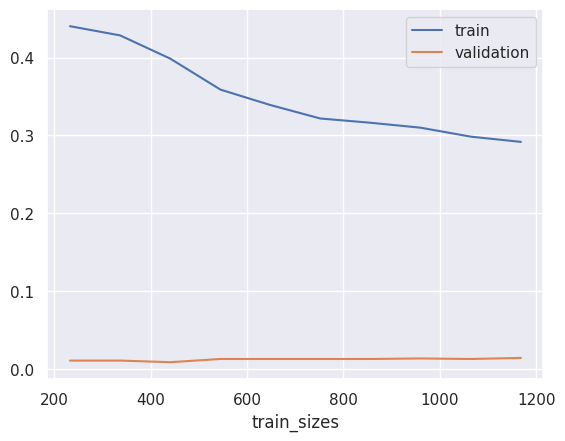

In [189]:
data_predictor.PredictionAnalysis(model, X_train, Y_train, splitNumber = 10, crossValidationNumber = 5)

In [190]:
Omni = OmniDS("train.csv", "test.csv", targetFeature = "SalePrice", idFeature = "Id", verbose = True)
Omni.Predict(verbose = True)

#Omni = OmniDS("train.csv", "test.csv", "trainLabels.csv", "Solution", "id")
#Omni.Predict(verbose = True)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


Starting auto fill for trainData
Missing values : 


,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
...,...,...
Heating,0,0.000000
HeatingQC,0,0.000000
MSZoning,0,0.000000
1stFlrSF,0,0.000000


Percent of mising value for PoolQC is 0.9952054794520548
Delete for PoolQC
Percent of mising value for MiscFeature is 0.963013698630137
Delete for MiscFeature
Percent of mising value for Alley is 0.9376712328767123
Delete for Alley
Percent of mising value for Fence is 0.8075342465753425
Delete for Fence
Percent of mising value for FireplaceQu is 0.4726027397260274
Delete for FireplaceQu
Percent of mising value for LotFrontage is 0.1773972602739726
Delete for LotFrontage
GarageYrBlt is extremely correlated to ['OverallQual', 'YearBuilt', 'YearRemodAdd', 'FullBath', 'GarageCars', 'GarageArea', 'SalePrice']
Delete for GarageYrBlt
Fill Na by the most frequent value for GarageCond
Fill Na by the most frequent value for GarageType
Fill Na by the most frequent value for GarageFinish
Fill Na by the most frequent value for GarageQual
Fill Na by the most frequent value for BsmtExposure
Fill Na by the most frequent value for BsmtFinType2
Fill Na by the most frequent value for BsmtCond
Fill Na by 

,Total,Percent
GarageFinish,78,0.053461
GarageQual,78,0.053461
GarageCond,78,0.053461
GarageType,76,0.052090
BsmtCond,45,0.030843
...,...,...
CentralAir,0,0.000000
Electrical,0,0.000000
1stFlrSF,0,0.000000
2ndFlrSF,0,0.000000


Fill Na by the most frequent value for GarageFinish
Fill Na by the most frequent value for GarageQual
Fill Na by the most frequent value for GarageCond
Fill Na by the most frequent value for GarageType
Fill Na by the most frequent value for BsmtCond
Fill Na by the most frequent value for BsmtQual
Fill Na by the most frequent value for BsmtExposure
Fill Na by the most frequent value for BsmtFinType2
Fill Na by the most frequent value for BsmtFinType1
Fill Na by the most frequent value for MasVnrType
Fill Na by the most frequent value for MSZoning
BsmtFullBath is extremely correlated to ['BsmtFinSF1']
Fill Na by the median for BsmtFullBath
Fill Na by the most frequent value for Utilities
Fill Na by the most frequent value for Functional
Fill Na by the median for BsmtHalfBath
BsmtFinSF1 is extremely correlated to ['TotalBsmtSF', '1stFlrSF', 'BsmtFullBath']
Fill Na by the median for BsmtFinSF1
Fill Na by the median for BsmtFinSF2
BsmtUnfSF is extremely correlated to ['TotalBsmtSF']
Fill Na

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
MSSubClass,1.000000,-0.139781,0.032628,-0.059316,0.027850,0.040581,-0.069836,-0.065649,-0.140759,-0.238518,-0.251758,0.307886,0.046474,0.074853,0.003491,-0.002333,0.131608,0.177354,-0.023438,0.281721,0.040380,-0.045569,-0.040110,-0.098672,-0.012579,-0.006100,-0.012037,-0.043825,-0.026030,0.008283,-0.007683,-0.013585,-0.021407,-0.084284
LotArea,-0.139781,1.000000,0.105806,-0.005636,0.014228,0.013788,0.214103,0.111170,-0.002618,0.260833,0.299475,0.050986,0.004779,0.263116,0.158155,0.048046,0.126031,0.014259,0.119690,-0.017784,0.190015,0.271364,0.154871,0.180403,0.171698,0.084774,-0.018340,0.020423,0.043160,0.077672,0.038068,0.001205,-0.014261,0.263843
OverallQual,0.032628,0.105806,1.000000,-0.091932,0.572323,0.550684,0.239666,-0.059119,0.308159,0.537808,0.476224,0.295493,-0.030429,0.593007,0.111098,-0.040150,0.550600,0.273458,0.101676,-0.183882,0.427452,0.396765,0.600671,0.562022,0.238923,0.308819,-0.113937,0.030371,0.064886,0.065166,-0.031406,0.070815,-0.027347,0.790982
OverallCond,-0.059316,-0.005636,-0.091932,1.000000,-0.375983,0.073741,-0.046231,0.040229,-0.136841,-0.171098,-0.144203,0.028942,0.025494,-0.079686,-0.054942,0.117821,-0.194149,-0.060769,0.012980,-0.087001,-0.057583,-0.023820,-0.185758,-0.151521,-0.003334,-0.032589,0.070356,0.025504,0.054811,-0.001985,0.068777,-0.003511,0.043950,-0.077856
YearBuilt,0.027850,0.014228,0.572323,-0.375983,1.000000,0.592855,0.249503,-0.049107,0.149040,0.391452,0.281986,0.010308,-0.183784,0.199010,0.187599,-0.038162,0.468271,0.242656,-0.070651,-0.174800,0.095589,0.147716,0.537850,0.478954,0.224880,0.188686,-0.387268,0.031355,-0.050364,0.004950,-0.034383,0.012398,-0.013618,0.522897
YearRemodAdd,0.040581,0.013788,0.550684,0.073741,0.592855,1.000000,0.128451,-0.067759,0.181133,0.291066,0.240379,0.140024,-0.062419,0.287389,0.119470,-0.012337,0.439046,0.183331,-0.040581,-0.149598,0.191740,0.112581,0.420622,0.371600,0.205726,0.226298,-0.193919,0.045286,-0.038740,0.005829,-0.010286,0.021490,0.035743,0.507101
BsmtFinSF1,-0.069836,0.214103,0.239666,-0.046231,0.249503,0.128451,1.000000,-0.050117,-0.495251,0.522396,0.445863,-0.137079,-0.064503,0.208171,0.649212,0.067418,0.058543,0.004262,-0.107355,-0.081007,0.044316,0.260011,0.224054,0.296970,0.204306,0.111761,-0.102303,0.026451,0.062021,0.140491,0.003571,-0.015727,0.014359,0.386420
BsmtFinSF2,-0.065649,0.111170,-0.059119,0.040229,-0.049107,-0.067759,-0.050117,1.000000,-0.209294,0.104810,0.097117,-0.099260,0.014807,-0.009640,0.158678,0.070948,-0.076444,-0.032148,-0.015728,-0.040751,-0.035227,0.046921,-0.038264,-0.018227,0.067898,0.003093,0.036543,-0.029993,0.088871,0.041709,0.004940,-0.015211,0.031706,-0.011378
BsmtUnfSF,-0.140759,-0.002618,0.308159,-0.136841,0.149040,0.181133,-0.495251,-0.209294,1.000000,0.415360,0.317987,0.004469,0.028167,0.240257,-0.422900,-0.095804,0.288886,-0.041118,0.166643,0.030086,0.250647,0.051575,0.214175,0.183303,-0.005316,0.129005,-0.002538,0.020764,-0.012579,-0.035092,-0.023837,0.034888,-0.041258,0.214479
TotalBsmtSF,-0.238518,0.260833,0.537808,-0.171098,0.391452,0.291066,0.522396,0.104810,0.415360,1.000000,0.819530,-0.174512,-0.033245,0.454868,0.307351,-0.000315,0.323722,-0.048804,0.050450,-0.068901,0.285573,0.339519,0.434585,0.486665,0.232019,0.247264,-0.095478,0.037384,0.084489,0.126053,-0.018479,0.013196,-0.014969,0.613581


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000


DataFrame Information


{'DataFrameCorrelation': 0.16730782575016714,
 'StandardDeviation': 30966.508725174157,
 'Mean': 5980.542727639001}

Processing Data
Group values of nominal categorical categories too big ​​together
no nominal categorical categories too big

Group values of numerical categories together
Create 107 categories for LotArea
Create 64 categories for BsmtFinSF1
Create 78 categories for BsmtUnfSF
Create 72 categories for TotalBsmtSF
Create 75 categories for 1stFlrSF
Create 42 categories for 2ndFlrSF
Create 86 categories for GrLivArea
Create 44 categories for GarageArea
Create 27 categories for WoodDeckSF
Create 20 categories for OpenPorchSF
Encode categorical categories
Label Encode MSZoning
Label Encode LotArea
Label Encode Street
Label Encode LotShape
Label Encode LandContour
Label Encode Utilities
Label Encode LotConfig
Label Encode LandSlope
Label Encode Neighborhood
Label Encode Condition1
Label Encode Condition2
Label Encode BldgType
Label Encode HouseStyle
Label Encode RoofStyle
Label Encode RoofMatl
Label Encode Exterior1st
Label Encode Exterior2nd
Label Encode MasVnrType
Label Encode ExterQual
Labe

array([[ 0.07337496, -1.65955367, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276, -1.62632254, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -1.5930914 , -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       ...,
       [ 0.30985939,  0.86601243, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276, -1.12785554, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276,  1.33124829, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113]])

y_train shape: (1460,)


0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

X_test shape: (1459, 264)


array([[-0.87256276, -0.16415269, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276,  1.43094168, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -0.36353949, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       ...,
       [-0.87256276,  0.00200297, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.66458604,  0.16815864, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -1.12785554, -0.06423821, ..., -0.05241424,
        -0.09103457, -0.11785113]])

Choose C-Support Vector Classification
Create {}
model SVC(random_state=42)
parameter {}

 Best Score : 0.014383561643835616 
 Best Params : {}
Create {}
Copy {}
ApplyFunction {}
model SVC(random_state=42)
parameter {}

 Best Score : 0.014383561643835616 
 Best Params : {}
Create {}
Copy {}
ApplyFunction {}
Best Parameters : SVC(random_state=42)


AttributeError: ignored